In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [21]:
# Define dataset directories
train_data_dir = 'C:/Development/Major_Project/Dataset/Train'
val_data_dir = 'C:/Development/Major_Project/Dataset/Validation'
test_data_dir = 'C:/Development/Major_Project/Dataset/Test'

In [23]:
# Define transformation for data augmentation and normalization
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])


In [52]:

# Define datasets
train_dataset = ImageFolder(train_data_dir, transform=transform)
val_dataset = ImageFolder(val_data_dir, transform=transform)
test_dataset = ImageFolder(test_data_dir, transform=transform)
test_dataset.classes

['Fake', 'Real']

In [25]:
# Define dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [31]:

# Define the model architecture
class MesoNet(nn.Module):
    def __init__(self):
        super(MesoNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(8)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(8, 8, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm2d(8)
        self.conv3 = nn.Conv2d(8, 16, kernel_size=5, stride=1, padding=2)
        self.bn3 = nn.BatchNorm2d(16)
        self.conv4 = nn.Conv2d(16, 16, kernel_size=5, stride=1, padding=2)
        self.bn4 = nn.BatchNorm2d(16)
        self.fc1 = nn.Linear(16 * 16 * 16, 16)
        self.fc2 = nn.Linear(16, 1)

    def forward(self, x):
        x = self.pool(self.bn1(nn.functional.relu(self.conv1(x))))
        x = self.pool(self.bn2(nn.functional.relu(self.conv2(x))))
        x = self.pool(self.bn3(nn.functional.relu(self.conv3(x))))
        x = self.pool(self.bn4(nn.functional.relu(self.conv4(x))))
        x = x.view(-1, 16 * 16 * 16)
        x = nn.functional.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

In [27]:
# Initialize the model
model = MesoNet().to(device)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.002)

In [54]:
# Define training function
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            print(labels)
            inputs, labels = inputs.to(device), labels.float().to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.unsqueeze(1))
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss}")

        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.float().to(device)
                outputs = model(inputs)
                val_loss += criterion(outputs, labels.unsqueeze(1)).item() * inputs.size(0)
                val_correct += ((outputs > 0.5) == labels.unsqueeze(1)).sum().item()
        
        val_loss /= len(val_loader.dataset)
        val_accuracy = val_correct / len(val_loader.dataset)
        print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

In [55]:
# Train the model
train(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs=10)

tensor([1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0,
        0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0])
tensor([0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1,
        1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0,
        1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0])
tensor([1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1,
        0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0])
tensor([0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0,
        0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0,
        1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1])
tensor([1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0,
        0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,

KeyboardInterrupt: 

In [ ]:
# torch.save(model.state_dict(), 'mesonet_model.pth')

PicklingError: Can't pickle <class '__main__.MesoNet'>: it's not the same object as __main__.MesoNet

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      5492
           1       0.50      1.00      0.66      5413

    accuracy                           0.50     10905
   macro avg       0.25      0.50      0.33     10905
weighted avg       0.25      0.50      0.33     10905

0.49637780834479595


c:\Development\Major_Project\myvenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Development\Major_Project\myvenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Development\Major_Project\myvenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


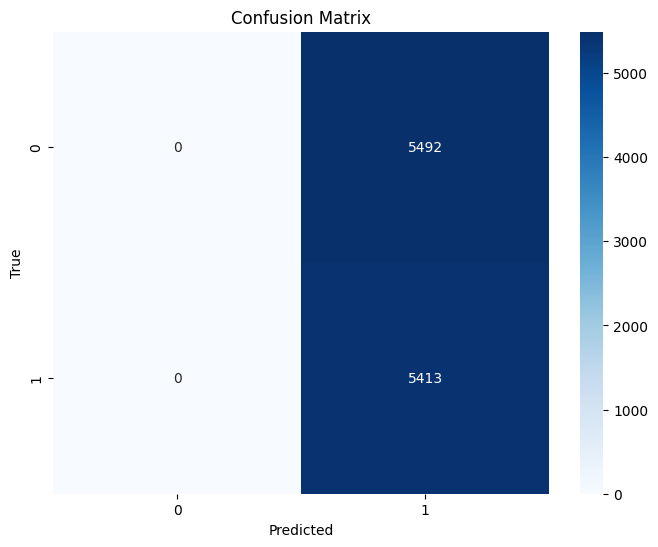

In [28]:
# Evaluate the model
from sklearn.metrics import accuracy_score
model.eval()
test_true_classes = []
test_pred_classes = []
with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.float().to(device)
        outputs = model(inputs)
        predicted_classes = (outputs > 0.5).cpu().numpy().astype(int)
        test_true_classes.extend(labels.cpu().numpy().astype(int))
        test_pred_classes.extend(predicted_classes.flatten().tolist())

   # Calculate evaluation metrics
print(classification_report(test_true_classes, test_pred_classes))
print(accuracy_score(test_true_classes,test_pred_classes))
cm = confusion_matrix(test_true_classes, test_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [2]:
# Load the trained model
from model import MesoNet
from PIL import Image
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=MesoNet().to(device)
model.load_state_dict(torch.load("mesonet_model.pth"))
print(model.parameters())
model.eval()

# Define predict function
def predict(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)
    
    # Move the input tensor to the same device as the model
    image = image.to(device)
    
    with torch.no_grad():
        outputs = model(image)
        return outputs[0]

# Test the prediction function
predictions = predict("Dataset/Test/Fake/fake_0.jpg")
print(predictions)
FakeOrReal="Real" if predictions>0.5 else "Fake"
print(FakeOrReal)


<generator object Module.parameters at 0x0000021290FBF3E0>
tensor([5.5551e-09], device='cuda:0')
Fake
